In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# local file
from pipeline import ContentBasedModelPipeline

# make the plot beautiful
sns.set_style('whitegrid')

In [3]:
def plot_results(results):
    """
    Plot the train/test RMSE results
    """
    # plot configuration
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # exponential moving average of RMSE to smooth out the output
    _ = results.ewm(halflife=50).mean().plot(ax=ax)
    _ = ax.set_xlabel("Number of Epochs")
    _ = ax.set_ylabel("RMSE")
    _ = ax.set_title("Content-based Model Learning Curve")

    return fig, ax

## Visualizing the training results

In [8]:
# read in pre-train model's training result
results = pd.read_feather('./data/model_sgd_regressor_scores.feather')

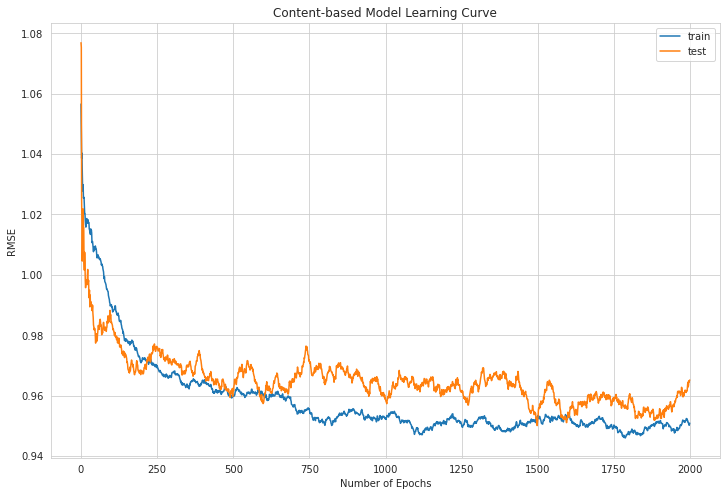

In [9]:
# plot the pre-train results
fig, ax = plot_results(results)

## Getting new Train/Test datasets

In [29]:
# read in pre-train model
sgd = joblib.load('./data/model_sgd_regressor.joblib')
pipeline = ContentBasedModelPipeline(random_seed=423942340)

In [30]:
from sklearn.metrics import mean_squared_error

# get a batch of train/test dataset
_, (X_train, y_train, X_test, y_test) = pipeline.get_batch_train_test(batch_size=5000)

# calculate RMSE for this batch
train_score = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
test_score = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))

print(f"Train RMSE = {train_score:0.3f}")
print(f"Test RMSE = {test_score:0.3f}")

Train RMSE = 0.938
Test RMSE = 0.968


## Rebuild the model from scratch or Do some additional trainings

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

pipeline = ContentBasedModelPipeline(random_seed=423942340)

# initilize the SGD Linear Model with L2 loss and penlity
sgd = SGDRegressor(loss='squared_error', penalty='l2', alpha=1e-4, fit_intercept=True)
scores = []

# training loop
n_epochs = 2000
batch_size = 1000
for epoch in tqdm(range(n_epochs)):
    # get train test data
    _, (X_train, y_train, X_test, y_test) = pipeline.get_batch_train_test(batch_size)

    # sgd batch fit
    sgd.partial_fit(X_train, y_train)

    # calcualte scores
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))
    scores.append((epoch, train_rmse, test_rmse))

# read the train/test RMSE results into pandas dataframe
results = pd.DataFrame(scores, columns=['epoch','train', 'test'])[['train','test']]

  0%|          | 0/2000 [00:00<?, ?it/s]

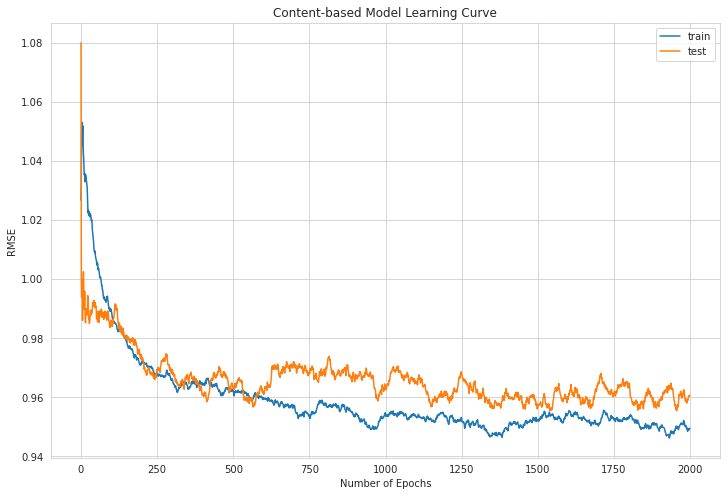

In [7]:
# plot out the new training results
fig, ax = plot_results(results)

### User specific Recommendations

In [4]:
sgd = joblib.load('./data/model_sgd_regressor.joblib')
pipeline = ContentBasedModelPipeline(random_seed=423942340)

In [5]:
user_id = 160747
df, (X_train, y_train, X_test, y_test) = pipeline.get_user_train_test(user_id)

In [6]:
df['predicted'] = sgd.predict(X_test)
df.sort_values('predicted', ascending=False).head(10)

rating  is_train train  \
userId movieId                           
160747 912         4.5     False  None   
       318         2.0     False  None   
       1203        1.5     False  None   
       923         4.5     False  None   
       1193        4.5     False  None   
       3307        3.5     False  None   
       2019        4.0     False  None   
       1212        4.0     False  None   
       858         5.0     False  None   
       908         4.5     False  None   

                                                             test  predicted  
userId movieId                                                                
160747 912      [0.008546880301537309, 0.008059827404043027, 0...   4.261257  
       318      [0.009142956625882312, 0.008621935696701923, 0...   4.253285  
       1203     [0.008955220868161848, 0.008444898257143769, 0...   4.224314  
       923      [0.008943132706910498, 0.008433498952382172, 0...   4.217842  
       1193     [0.008933590921780131, 0.008424500915839716, 0...   4.204829  
       3307     [0.009013047697913992, 0.008499429764627435, 0...   4.199435  
       2019     [0.008748464679061922, 0.008249924285346908, 0...   4.196044  
       1212     [0.008620891141241998, 0.008129620658774907, 0...   4.186250  
       858      [0.00885161437382679, 0.008347195887060462, 0....   4.179354  
       908      [0.008950044579005488, 0.008440016944229377, 0...   4.173271